#Siamese Network using Contrastive Loss on MNIST

Insipired by Pyimagesearch and several code snippets were used from their site to help build this notebook <br> https://pyimagesearch.mykajabi.com/products/pyimagesearch-university-full-access-plan/categories/4672019/posts/15978721

### Importing dependencies

In [ ]:
import os
import cv2
import json
import time
import random
import csv
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from imutils.paths import list_images
from imutils import build_montages
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, MaxPool2D, GlobalAveragePooling2D, Lambda, Conv2D, concatenate, ZeroPadding2D, Layer, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow import keras
from sklearn.decomposition import PCA
from random import shuffle
from tqdm import tqdm

# Creating function to create pairs

In [ ]:
# Positive and negative pairs will be created with this function

def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []

	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]

		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]

		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])

		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]

		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])

	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [ ]:
(trainX, trainY), (testX, testY) = tf.keras.datasets.fashion_mnist.load_data();

# build the positive and negative image pairs
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

### Visualizing the pairs we created

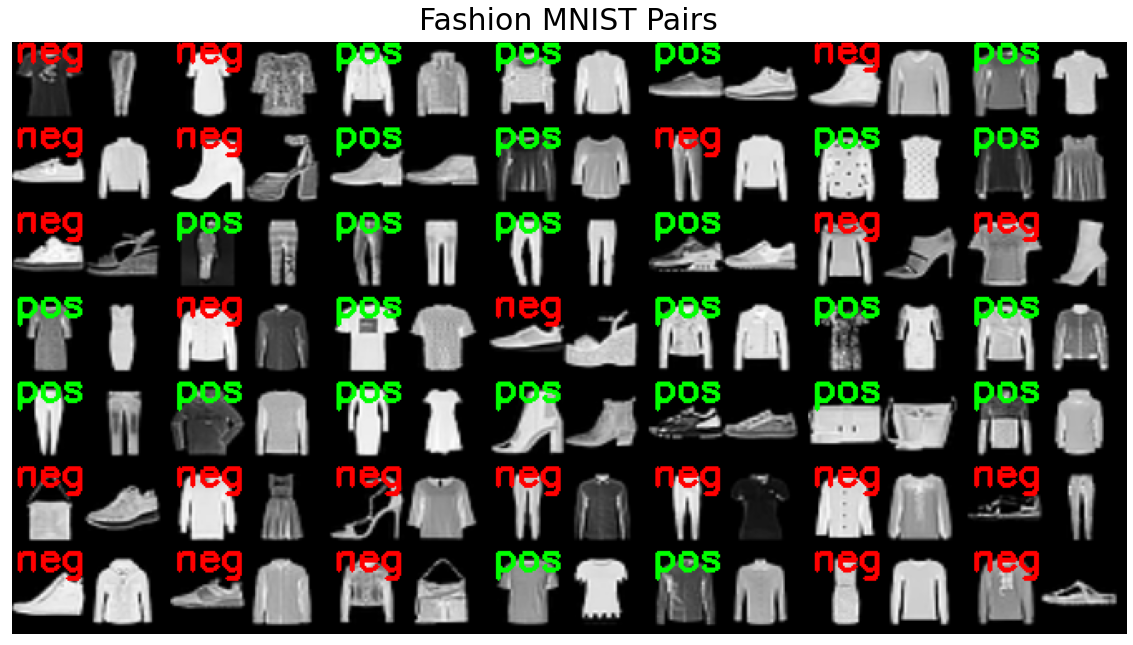

In [ ]:
images = []

# loop over a sample of our training pairs
for i in np.random.choice(np.arange(0, len(pairTrain)), size=(49,)):
	# grab the current image pair and label
	imageA = pairTrain[i][0]
	imageB = pairTrain[i][1]
	label = labelTrain[i]

	# "padding" the pair with four pixels around border 
	output = np.zeros((36, 60), dtype="uint8")
	pair = np.hstack([imageA, imageB])
	pair = pair.reshape(28, 56)
	output[4:32, 0:56] = pair

	# set the text label for the pair along with what color we are going to draw the pair in (green for a "positive" pair and
	# red for a "negative" pair)
	text = "neg" if label[0] == 0 else "pos"
	color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)

	# create a 3-channel RGB image from the grayscale pair, resize
	# it from 28x28 to 96x51 (so we can better see it), and then
	# draw what type of pair it is on the image
	vis = cv2.merge([output] * 3)
	vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
	cv2.putText(vis, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75,	color, 2)

	# add the pair visualization to our list of output images
	images.append(vis)

# construct the montage for the images
montage = build_montages(images, (96, 51), (7, 7))[0]

# convert the image frame BGR to RGB color space and display it
image = cv2.cvtColor(montage, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.title('Fashion MNIST Pairs', fontsize=30, y=1.01)
plt.grid(False)
plt.show()

#Preprocessing data for our model

In [ ]:
(trainX, trainY), (testX, testY) = tf.keras.datasets.fashion_mnist.load_data();

trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# prepare the positive and negative pairs
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

# Defining Our Loss Function - Contrastive Loss function

![Assignment 1.jpg](https://drive.google.com/uc?export=view&id=1bL5-uoNNXySi6Gvgp9JXLFE9j5iOgvPd)

Contrastive loss looks suspiciously like the softmax function. That’s because it is, with the addition of the vector similarity and a temperature normalization factor. The similarity function is just the cosine distance that we talked about before. The other difference is that values in the denominator are the cosign distance from the positive example to the negative samples. Not very different from CrossEntropyLoss. <br> https://towardsdatascience.com/contrastive-loss-explaned-159f2d4a87ec

In [ ]:
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)

	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

	# return the computed contrastive loss to the calling function
	return loss

# Building and Training our Siamese Network

In [ ]:
def plot_training(H):
	""" construct a plot that plots and saves the training history """
	plt.figure(figsize=(10,10))
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")


def build_siamese_model(inputShape, embeddingDim=48):
	"""Building our siamese model """
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)

	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)

	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)

	# build the model
	model = Model(inputs, outputs)

	# return the model to the calling function
	return model

In [ ]:
# configure the network and then constructing it
imgA = Input(shape=(28, 28, 1))
imgB = Input(shape=(28, 28, 1))
featureExtractor = build_siamese_model((28, 28, 1))
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1598 - val_loss: 0.1395
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1358 - val_loss: 0.1322
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1295 - val_loss: 0.1253
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1259 - val_loss: 0.1232
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1232 - val_loss: 0.1239
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1217 - val_loss: 0.1199
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1205 - val_loss: 0.1169
Epoch 8/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1197 - val_loss: 0.1162
Epoch 9/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1186 - val_loss: 0.1160
Epoch 10/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1180 - val_loss: 0.1183

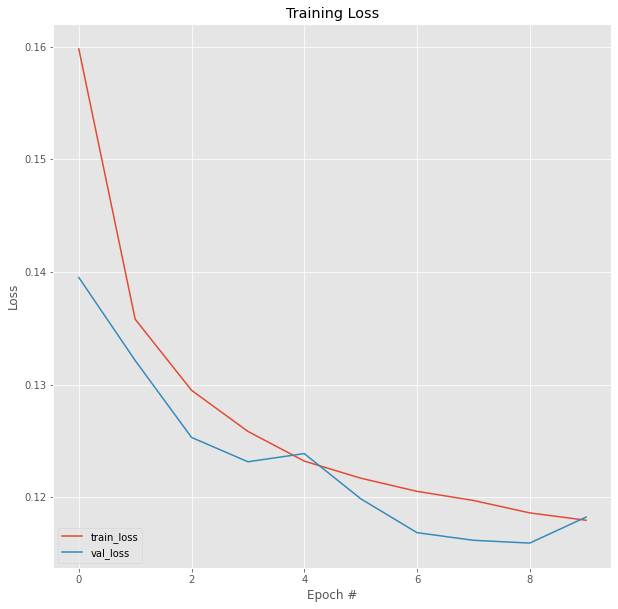

In [ ]:
# compile the model
model.compile(loss=contrastive_loss, optimizer="adam")

# train the model
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=128,
	epochs=10)

# plot the training history
plot_training(history);

###Visualizing Contrastive Loss over test images

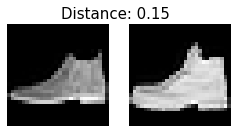

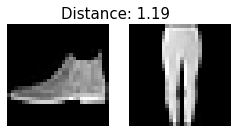

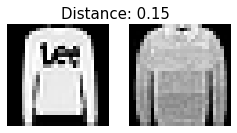

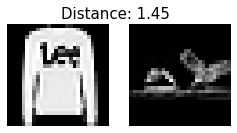

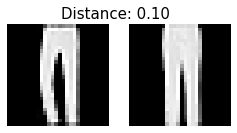

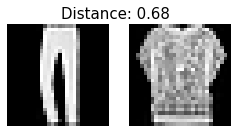

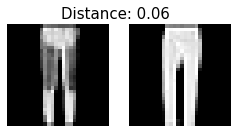

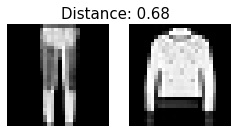

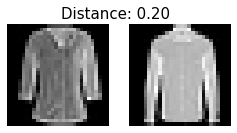

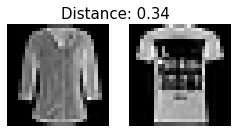

In [ ]:
# Getting 10 pairs of images
pairs = (pairTest, labelTest)[0][:10]

for (i, (imageA, imageB)) in enumerate(pairs):
  origA = imageA.copy()
  origB = imageB.copy()

  origA = origA.reshape(28,28)
  origB = origB.reshape(28,28)

  imageA = np.expand_dims(imageA, axis=0)
  imageB = np.expand_dims(imageB, axis=0)

	# use our siamese model to make predictions on the image pair, indicating whether or not the images belong to the same class
  preds = model.predict([imageA, imageB])
  proba = preds[0][0]

  fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
  plt.suptitle("Distance: {:.2f}".format(proba), fontsize=15)

  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(origA, cmap=plt.cm.gray)
  plt.axis("off")

  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(origB, cmap=plt.cm.gray)
  plt.axis("off")

  plt.show()

### As we can see our model is performing well, as the distance between similar items is smaller than dissimilar ones!